In [1]:
from transformers import logging

import random
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import re
import string

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

2022-06-19 14:56:34.550651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-19 14:56:34.550678: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# setting up seed
seed = 123

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

logging.set_verbosity_error()

In [3]:
BATCH_SIZE = 128 # batch size used on the train and validation set
NUM_TRAIN_EPOCHS = 5 # number of iterations for the model training
MAX_SEQ_LENGTH = 128 # used to cut/pad the text into tokens

In [4]:
# Loading the dataset
path = '../../datasets/'
taxonomy = pd.read_csv(path + 'taxonomy.csv')

In [5]:
# Encoding the labels to binary values
bin_encoder = LabelEncoder()
taxonomy['label'] = bin_encoder.fit_transform(taxonomy['label'])

In [6]:
# Randomly sample four sets: pool of train set (70%), validation set (10%), test set (20%)
train_split, val_split, test_split = np.split(taxonomy.sample(frac=1, random_state=seed), [int(.7*len(taxonomy)), int(.8*len(taxonomy))])

# Creating TF Datasets for faster prefetching and parallelization
train_dataset = tf.data.Dataset.from_tensor_slices((train_split['query'], train_split['label']))
val_dataset = tf.data.Dataset.from_tensor_slices((val_split['query'], val_split['label']))
test_dataset = tf.data.Dataset.from_tensor_slices((test_split['query'], test_split['label']))

print(f"Initial training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Initial training set size: 3500
Validation set size: 500
Testing set size: 1000


2022-06-19 14:56:37.472995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-19 14:56:37.473019: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-19 14:56:37.473037: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jasmine): /proc/driver/nvidia/version does not exist
2022-06-19 14:56:37.473265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Cleaning up the text and vectorizing it
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

vectorizer = layers.TextVectorization(
    3000, standardize=custom_standardization, output_sequence_length=MAX_SEQ_LENGTH
)
# Adapting the dataset
vectorizer.adapt(
    train_dataset.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
)

def vectorize_text(text, label):
    text = vectorizer(text)
    return text, label

train_dataset = train_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(BATCH_SIZE).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.batch(BATCH_SIZE).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)

In [8]:
# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

In [9]:
def create_model():
    model = keras.models.Sequential(
        [
            layers.Input(shape=(MAX_SEQ_LENGTH,)),
            layers.Embedding(input_dim=3000, output_dim=MAX_SEQ_LENGTH),
            layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
            layers.GlobalMaxPool1D(),
            layers.Dense(12, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.summary()
    return model

In [10]:
def train_full_model(
    train_dataset,
    val_dataset,
    test_dataset
):
    # Creating lists for storing metrics
    losses, val_losses, accuracies, val_accuracies = [], [], [], []

    model = create_model()
    # We will monitor the false positives and false negatives predicted by our model
    # These will decide the subsequent sampling ratio for every Active Learning loop
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives()
        ],
    )

    # Defining checkpoints.
    # The checkpoint callback is reused throughout the training since it only saves the best overall model.
    checkpoint = keras.callbacks.ModelCheckpoint(
        "LSTM_Full.h5", save_best_only=True, verbose=1
    )
    # Here, patience is set to 4. This can be set higher if desired.
    early_stopping = keras.callbacks.EarlyStopping(patience=4, verbose=1)

    print(f"Starting to train with {len(train_dataset)} samples")
    # Initial fit with a small subset of the training set
    history = model.fit(
        train_dataset.cache().shuffle(500).batch(BATCH_SIZE),
        epochs=NUM_TRAIN_EPOCHS,
        validation_data=val_dataset,
        callbacks=[checkpoint, early_stopping],
    )

    # Appending history
    losses, val_losses, accuracies, val_accuracies = append_history(
        losses, val_losses, accuracies, val_accuracies, history
    )

    # Plotting the overall history and evaluating the final model
    plot_history(losses, val_losses, accuracies, val_accuracies)
    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 128)          384000    
                                                                 
 bidirectional (Bidirectiona  (None, 128, 64)          41216     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 12)                780       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

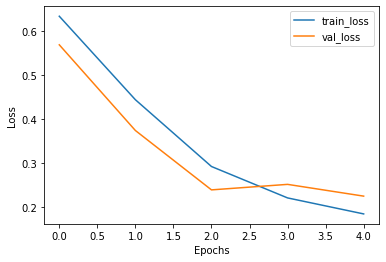

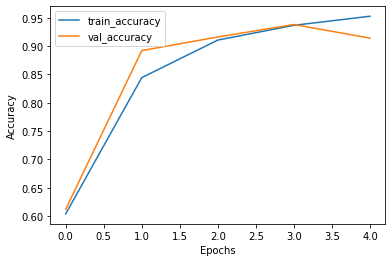

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'loss': 0.25306791067123413, 'binary_accuracy': 0.9200000166893005, 'false_negatives': 51.0, 'false_positives': 29.0}
----------------------------------------------------------------------------------------------------


In [11]:
# Training the model
full_dataset_model = train_full_model(train_dataset, val_dataset, test_dataset)